# Build a new BoM from 3dx files

This is reading in extracts produced by 3dx, adding the function group and system/subsystem, and doing the roll up quantity calcs in the absence of 3DX doing that.

The script does the following functions that is missing from 3DX currently:

* Populate Function Group/System/Sub System – not fully populated in 3DX for all parts and this is needed downstream for reporting
* Add Percentage Missing calculations for all attributes/columns for EDAG reporting
* Create a matching key for Smartsheets processing
* Add last Export Date to top of export and as a column 
* Add BOM COUNT validation column
* Add Parent Part column – not maintained in 3DX and requested by downstream systems
* Validates all mandatory attributes are included before processing any further
* If Quantity doesn’t exist (comes only from XEN tool) then group parts and create Quantity column (removes the reliance on XEN license)
* Clear zero values, ‘not set’ and blank spaces from 3DX extract – zero does not mean the attribute is populated and needs to be removed to show it requires completion
* Add Part Number validation and report where it doesn’t adhere to part numbering standard – creates validation columns at the far right of the export
* Force the order of selected key attributes to the left as not always maintained in 3DX extract files
* Derive the export folder to send file to and name file for Data Shuttle to pick up – top level ‘Title’ (ie T48e-01-Z00001 = VP 5 door master product - T48e-01-Z00001’
* Identify where a part is a lowest level child part and add a ‘has_child’ column to support Smartsheet Mass calculations


In [31]:
import pandas as pd
import numpy as np
import os
import sys
import re
import io
import time
import openpyxl
from openpyxl import load_workbook
import xlwings as xw
import glob
import configparser
from pathlib import Path
import datetime
import platform


In [32]:
def find_files(download_dir):
    # find any changed files changed in past 2hrs in the downloads directory
    dirpath = download_dir
    past = time.time() - 2*60*60 # 2 hours
    files = []
    for p, ds, fs in os.walk(dirpath):
        for fn in fs:
            # was using this to filter what filenames to find
            if 'ENO' in fn:            
                filepath = os.path.join(p, fn)
                if os.path.getmtime(filepath) >= past:
                    files.append(filepath)

    return files

In [33]:
def open_file(file):
    # get 3dx extract
    print ("opening {} at: {}".format(file, time.strftime("%H:%M:%S", time.localtime())))
    with open(file, "rb") as f:
        try:

            if 'csv' in file:
                BOM = pd.DataFrame()
                BOM = pd.read_csv(f, low_memory=False) 
                # skip first n rows that are header information out of 3DX
                if 'Level' not in BOM.columns:
                    print ("didn't get the column headers so finding them myself")            
                    n = BOM[BOM.iloc[:, 0] == 'Level'].index.values[0]
                    # create the column headers
                    BOM.columns = BOM.iloc[n]
                    # drop the top rows above the header row we found
                    BOM = BOM[n+1:]

            if 'xls' in file:
                # BOM = pd.read_csv(f, low_memory=False, skiprows=8) 
                BOM = pd.read_excel(f)             
            # sheetnames = [sheet for sheet in f.sheet_names]
        except Exception as e:
            print ("{}".format(e))

    return BOM


In [34]:
def add_function_group(df):
    # Add Function and Sub Group if it doesn't already exist

    # - Level 0 = Model Variant   
    # - Level 1 = Function Group Area   
    # - Level 2 = System   
    # - Level 3 = Sub Systems
    # - level 4 = AMs/SAs??

    # Find each one and forward fill to the next occurrence
    # function group - level 1
    df['Function Group'] = np.where(df['Level'].isin([0,1]), df['Description'], None)
    df['Function Group'] = df['Function Group'].ffill()

    # System - level 2
    df['System'] = np.where(df['Level'] == 2, df['Description'], None)
    df['System'] = np.where(df['Level'] >= 2, df['System'].ffill(), None)

    # SUB_System = level 3
    df['Sub System'] = np.where(df['Level'] == 3, df['Description'], None)
    df['Sub System'] = np.where(df['Level'] >= 3, df['Sub System'].ffill(), df['Sub System'])

    # Level 4 - for grouping mass and cost roll up for Carlos/smartsheets
    df['Level_4_Parent'] = np.where(df['Level'] == 4, df['Title'], None)
    df['Level_4_Parent'] = np.where(df['Level'] >= 4, df['Level_4_Parent'].ffill(), df['Level_4_Parent'])

    return df

In [35]:
def rename_columns(df):
    # keep python index as 'orig_sort' - useful for knowing you've maintained the BoM structure/order
    df.reset_index(inplace=True)
    df.rename(columns={'index':'orig_sort'}, inplace=True)

    # sometimes column came through as Title (Instance) 
    try:
        df.rename(columns={'Title (Instance)':'Instance Title'}, inplace=True)
    except ValueError:
        print ("didn't find Title (Instance) to rename")

    # 3dx calls Quantity Occurrences
    try:
        df.rename(columns={'Occurrences':'Quantity'}, inplace=True)
    except ValueError:
        print ("didn't find Occurrences to rename")

    # replace any Mass (kg) columns with Mass
    df.columns = df.columns.str.replace('Mass (kg)', 'Mass')


    return df  

In [36]:
def add_matching_key(df):
    # for us in smartsheets
    df['Matching Key'] = np.where(df['Parent Part'].isna(), df['Title'].astype(str), df["Title"].astype(str) + df["Parent Part"].astype(str))
    # force matching key to always be upper case whilst there is inconsistency within 3dx.  Otherwise, doesn't match dup parts
    df['Matching Key'] = df['Matching Key'].str.upper()
    # build cumulative count for each part
    df['cumcount'] = df.groupby('Matching Key').cumcount()+1
    # not interested in the first occurrence of a part - blank out the first cumcount of each group
    df['cumcount'] = np.where(df['cumcount']==1, '', df['cumcount'])
    df['Matching Key'] = df['Matching Key'].astype(str) + df['cumcount'].astype(str)

    return df

In [37]:
def add_smartsheet_cols(df, extract_date):
    # need to correct the percent missing for matching key column
    df.loc['percent_missing','Matching Key'] = 0
    df['Last Export Date'] = extract_date

    return df

In [38]:
def mandatory_attributes(bom_cols):
    # read in mandatory fields from file in same directory
    with open('mandatory_attributes.ini', 'r') as f:
        lst = f.readlines()

    mand_cols = [line.rstrip() for line in lst]

    missing_cols = list(set(mand_cols) - set(bom_cols))

    if len(missing_cols) > 0:
        print ("missing mandatory attributes: {}".format(missing_cols))
        sys.exit()

    return mand_cols

In [39]:
def order_columns(df):
    # this specifies the order of the left most cols.  Columns not mentioned below then appear alphabetically afterwards
    cols_to_order = ['BOM COUNT',
        'Matching Key',
        'Last Export Date',
        'orig_sort',
        'Function Group',
        'System',
        'Sub System',
        'Level_4_Parent',
        'Level',
        'Title',
        'Parent Part',
        'Revision',
        'Description',
        'Name',
        'Quantity',
        'Source Code',
        'UOM',
        'Provide',
        'Actual Mass',
        'CAD Mass',
        'CAD Material',
        'Programme Maturity']
        # 'Subtype']
    
    # # write out mandatory attributes to local file.  Not reading in from here as there is always some code change required anyway!
    # with open('mandatory_attributes.ini', 'w') as f:
    #     for col in cols_to_order:
    #         # ignore the internal cols I create
    #         if col not in (['Matching Key','Last Export Date','orig_sort','Parent Part']):
    #             f.write('{}\n'.format(col))

    try:
        ordered_cols = cols_to_order + (df.columns.sort_values().drop(cols_to_order).tolist())
        df = df[ordered_cols]
    except KeyError as e:
        raise Exception ("Missing an expected column in the extract: {}".format(e))

    return df

In [40]:
def create_sa_index(df):
    # fill level 3s with orig_sort
    # ffill everything with the level 3 orig_sort
    # fill level 4s with the level 3 orig_sort + its own orig_sort
    # fill < level 3 with own orig_sort
    # NaN > level 4 and refill with the sa_index from level 4 above
    df['SA_Index'] = np.where(df['Level'] == 3, df['orig_sort'].astype(str), np.nan)
    df['SA_Index'] = df['SA_Index'].ffill()
    df['SA_Index'] = np.where(df['Level'] == 4, df['SA_Index'] + '_' + df['orig_sort'].astype(str), df['SA_Index'])
    # forward fill so that > Level 5 get the same index
    df['SA_Index'] = np.where(df['Level'] < 3, df['orig_sort'].astype(str), df['SA_Index'])
    df['SA_Index'] = np.where(df['Level'] > 4, np.nan, df['SA_Index'])
    df['SA_Index'] = df['SA_Index'].ffill()


    return df

In [41]:
def create_sa_index2(df):
    # this was attempting to rely on 3dx labelling of an Assembly - didn't work all of the time
    df['SA_Index'] = np.where(df['Assembly'], df['orig_sort'].astype(str), np.nan)
    df['SA_Index'] = df['SA_Index'].ffill()

    return df

In [42]:
def add_quantities(df):

    # if the extract hasn't come with quantity column then we need to calculate our own grouping of like parts together
    # this is only being done for level 4 and greater - level 4 is assumed to be assembly level
    # there is a potential problem with this if the extract is not produced for the top level part of a structure
    
    # groupby:
    # SA_Index - created earlier, this will group the parts within an assembly (level 4 and greater) 
    # Title - this is the part number
    # Parent Part - created earlier, this will group only parts at the same level with the same parent
    # Level - this is probably not required if we are using parent part, but ensures we group at the same level

    # groupby Title and sum (size).  Save as a new df called qty
    qty = BOM_pp.groupby(['SA_Index','Title','Parent Part','Level'], dropna=False).size().reset_index(name='Quantity')
    # qty = BOM_pp.groupby(['Title','Parent Part','Level'], dropna=False).size().reset_index(name='Quantity')

    # merge qty with BOM on SA_Index to get all the other columns back
    qty2 = pd.merge(qty, BOM_pp, on=['SA_Index','Title','Parent Part','Level'])
    # qty2 = pd.merge(qty, BOM_pp, on=['Title','Parent Part','Level'])
    # qty2 = pd.concat([qty, BOM_pp])

    # need to drop dups using only a subset of cols, creating new_bom df
    new_bom = qty2.drop_duplicates(subset=['SA_Index','Title','Parent Part', 'Level'])
    # new_bom = qty2.drop_duplicates(subset=['Title','Parent Part', 'Level'])
    # sort the new_nom df by the orig_sort field to make sure it's the order it came out of 3dx
    new_bom = new_bom.sort_values(by='orig_sort')
    
    # don't think there are any names to rename?
    new_bom.rename(columns={
        'Title_y':'Title',
        'Parent Part_x':'Parent Part',
        'Quantity_x':'Quantity',
        'Level_x':'Level'
    }, inplace=True)    

    return new_bom


In [43]:
def create_parent_part(df):
    # reset index before trying to update, otherwise multiple rows get updated
    df.reset_index(inplace=True, drop=True)
    
    df['Parent Part'] = None

    level = {}
    previous_parent_part=0

    for i, row in df.iterrows():
        current_part_number = row['Title']
        current_part_level = row['Level']

        # write part number to dictionary under current part level
        level[current_part_level] = current_part_number

        # reset higher levels for each assembly
        # remove entries from higher levels
        keys = [k for k in level if k > current_part_level]
        for x in keys:
            del level[x]

        if current_part_level > 0:
            # get the max part level from the level dictionary that's less than current part level
            previous_parent_level = max(k for k in level if k < current_part_level)

            # update the parent part
            # print (i, "Parent part {} from previous level {}".format(level[previous_parent_level], previous_parent_level))
            df.at[i,'Parent Part'] = level[previous_parent_level]
    return df

In [44]:
def create_gparent_part(df):
    # reset index before trying to update, otherwise multiple rows get updated
    df.reset_index(inplace=True, drop=True)
    
    df['Parent Part'] = None
    df['Matching Key'] = None

    level = {}
    previous_part_level=0
    gparent_part_level=0

    for i, row in df.iterrows():
        current_part_number = row['Title']
        current_part_level = row['Level']

        # write part number to dictionary under current part level
        level[current_part_level] = current_part_number

        # reset higher levels for each assembly
        # remove entries from higher levels
        keys = [k for k in level if k > current_part_level]
        for x in keys:
            del level[x]

        if current_part_level > 0:
            # get the max part level from the level dictionary that's less than current part level
            previous_part_level = max(k for k in level if k < current_part_level)

            # update the parent part
            # print (i, "Parent part {} from previous level {}".format(level[previous_parent_level], previous_parent_level))
            df.at[i,'Parent Part'] = level[previous_part_level]
        
        # if previous_part_level > 0:
            # get the max part level from the level dictionary that's less than previous parent level
            # gparent_part_level = max(k for k in level if k < previous_part_level)
            # gparent_part_level = ''.join((level.values()))


            # update the parent part
            # print (i, "Parent part {} from previous level {}".format(level[previous_parent_level], previous_parent_level))
        df.at[i,'Matching Key'] = ''.join((level.values()))


    return df

In [45]:
def convert_to_xml(df):
    BOM_xml = df
    # get rid of spaces, slashes and chars xml can't handle
    BOM_xml.columns = df.columns.str.replace(' ', '_')
    BOM_xml.columns = df.columns.str.replace('/', '_')
    BOM_xml.columns = df.columns.str.replace('&', '')

    return df

In [46]:
def data_shuttle_folder(product):
    # After update of BoM names
    # •	XP 5 door master product - T48e-01-Z00001 
    # •	XP 3 door master product - T48e-02-Z00001
    # •	VP 5 door master product – T48e-01-Z00005
    # •	VP 3 door master product - T48e-02-Z00005

    config = configparser.ConfigParser()
    config_file = 'product_structures_config.ini'
    config.read(config_file)

    # read the Product_Structures section and look up the product
    try:
        ds_folder = config['Product_Structures'][product]
    except KeyError:
        print ("No entry in file {}, section: Product_Structures, for key {}.  Using 'default'".format(config_file, product))
        ds_folder = 'default'

    return ds_folder
    

    # if 'T48e-01-Z00001' in product:
    #     return 'VP 5 door master product - T48e-01-Z00001'
    # elif 'T48e-02-Z00001' in product:
    #     return 'XP 3 door master product - T48e-02-Z00001'
    # elif 'T48e-01-Z00005' in product:
    #     return 'XP 5 door master product – T48e-01-Z00005'
    # elif 'T48e-02-Z00005' in product:
    #     return 'VP 3 door master product - T48e-02-Z00005'
    # elif 'T48e-M1-Z00001' in product:
    #     return 'Chassis Mule - T48e-M1-Z00001'
    # elif 'T48e-01-Z00003' in product:
    #     return 'Kinematics and compliance - T48e-01-Z00003'
    # elif 'T53-Z00001' in product:
    #     return 'T53 - Z00001 - BOM Export'
    # elif 'T53-Z00002' in product:
    #     return 'T53 - Z00002 - BOM Export'
    # else:
    #     return 'default'


In [47]:
def COG_split(df):
    # split the COG field (where it is populated) into COG x, COG y, COG z 
    # need to make sure COG is a string field - if is it completely empty, all nan will make it float
    df.COG = df.COG.astype('object')

    # then try to split into three columns
    try:
        df[['COG X', 'COG Y', 'COG Z']] = df['COG'].str.split(',', expand=True)
    except ValueError:
        # will fail if there is nothing to split on, so create 3 cols with NaN
        df[['COG X', 'COG Y', 'COG Z']] = np.NaN

    return df

In [48]:
def clear_zero_values(df):
    value_cols = df.select_dtypes(exclude=[object]).columns
    value_cols = value_cols.drop(['Level','orig_sort'])

    # convert 0.0 to na
    df[value_cols] = np.where(df[value_cols] == 0, np.NaN, df[value_cols])

    # for COG, convert 0,0,0 to na
    df['COG'] = np.where(df['COG'] == '0,0,0', np.NaN, df['COG'])

    return df

In [49]:
def clear_not_set_values(df):
    df = df.replace('Not Set', np.NaN)

    return df

In [50]:
def set_na_values(df):
    # populate Provide with 'N/A' for source code SYS and ENG
    df['Provide'] = np.where(df['Source Code'].isin(['SYS','ENG']), 'N/A', df['Provide'])

    return df

In [51]:
def percent_missing(df):
    df.loc['percent_missing'] = None
    df.loc['percent_missing'] = df.isnull().sum(axis=0) * 100 / len(df)
    # df.loc['percent_missing'] = df.loc['percent_missing'].astype(int)
    df.loc['percent_missing','orig_sort'] = 'percent_missing'
    new_df = pd.concat([df.iloc[-1:].copy(), df.iloc[:-1].copy()])

    return new_df

In [52]:
def validate_part_no(df):

    # ? means the preceding bracketed group is optional (optional s,S and trailing X)
    # pattern = r'([A-Z]\d{2}([s,S])?-[A-Z]\d{4}(X)?)'
    # pattern = r'[A-Z]\d{2}[e]-[A-Z]\d{5}+X?'
    # pattern = r'([A-Z]\d{2}[e])-([A-Z])(\d{5})(X)'
    pattern = r'([A-Z]\d{2}[e])-(\w[A-Za-z0-9]*)?-?([A-Z])(\d{5})(X)?'
    df[['extr_project','extr_invalid_code','extr_function','extr_pn','extr_maturity']] = df['Title'].str.extract(pattern, expand=True)

    df['part_number_length'] = df['Title'].str.len()

    return df


In [53]:
def clear_blanks(df):
    # replace an empty string and records with only spaces
    df = df.replace(r'^\s*$', np.nan, regex=True)

    return df

In [54]:
def convert_date(x):
    try:
        return dt.datetime.strptime(x, '%Y-%m-%d')
    except:
        return pd.NaT

In [55]:
def write_to_excel(df, outfile):
    from openpyxl import load_workbook

    # update if exists
    try:
        wb = load_workbook(outfile)
        with pd.ExcelWriter(outfile, engine='openpyxl') as writer:
            writer.workbook = wb
            df.to_excel(writer, index=False)
            print ("BOM written to existing file {}".format(outfile))
    except (FileNotFoundError):
        df.to_excel(outfile, index=False)
        print ("BOM written to new file {}".format(outfile))


XCADEmbeddedCmp means it is an Embedded Component, which means its behaves like an Assembly (so it has child parts), but it usually only exists in the context of its parent. So for your purposes, it should be flagged as an Assembly. 

I think KPKV5EquivalentComputed is just another element of the inertia measure function which is on the part template, so it appears whether or not its had the mass calculated. For the two parts that don't have KPKV5EquivalentComputed, it might mean they were created from a different template. 

‘XCAD Extension’ and ‘XCADExtension’ are the same, I think its just displaying differently on its own than when its concatenated into a string with other values. If they don't have 3DPart then they are Assemblies. 


In [56]:
def split_subtype(df):
    
    df.Subtype.replace({'XCAD Extension':'Assembly',
                        'XCADExtension':'Assembly',
                        'XCADEmbeddedCmp':'Assembly',
                            '3DPart':'Part3D',
                            'XCADExposedPLMParameterSet':'COG and Mass Calculated'}, 
                            regex=True,
                            inplace=True)
                
    df.Subtype = df.Subtype.str.split(',')
    df.Subtype = df.Subtype.fillna("").apply(list)
    # dynamically create columns
    for i in sorted(set(sum(df.Subtype.tolist(),[]))):
        # Create a new column 
        df[i] = df.Subtype.apply(lambda x: 1 if i in x else 0)

    return df

In [57]:
def has_child(df):
    df['has_child'] = np.where(df.Level>=df.Level.shift(-1), 0, 1)
    # set last row to has_child = 0 because there isn't anything below it
    df.loc[df.index[-1],'has_child'] = 0

    return df

# Main processing

In [58]:
if __name__ == '__main__':

    if 'macOS' in platform.platform():
        # set some defaults for testing on mac
        download_dir = Path('/Users/mark/Downloads')
        user_dir = download_dir
        sharepoint_dir = download_dir

    elif os.getlogin() == 'mark_':
        # my test windows machine
        download_dir = Path('C:/Users/mark_/Downloads')
        user_dir = download_dir
        sharepoint_dir = download_dir        

    else:
        # personal one drive
        user_dir = 'C:/Users/USERNAME'

        # replace USERNAME with current logged on user
        user_dir = user_dir.replace('USERNAME', os.getlogin())

        # read in config file
        config = configparser.ConfigParser()
        config.read('user_directory.ini')

        # read in gm_dir and gm_docs from config file
        gm_dir = Path(config[os.getlogin().lower()]['gm_dir'])
        gm_docs = Path(config[os.getlogin().lower()]['gmt'])
        # this may find more than one sharepoint directory
        # sharepoint_dir = user_dir + "/" + gm_dir + "/" + gm_docs
        sharepoint_dir = Path(user_dir / gm_dir / gm_docs)

        # download_dir = os.path.join(sharepoint_dir, 'Data Shuttle', 'downloads')
        download_dir = Path(sharepoint_dir / 'Data Shuttle' / 'downloads')

    files = find_files(download_dir)

    if len(files) == 0:
        print ("No files found in {}".format(download_dir))
       

    else:
        dict_df = {}

        # loop in case more than 1 file
        for file in files:
            BOM = pd.DataFrame()
            BOM = open_file(file)
            orig_bom = BOM.copy()
            
            time_format = "%Y-%m-%d %H:%M"
            curr_time = time.strftime(time_format, time.localtime())

            # check mandatory attributes are present
            mandatory_cols = mandatory_attributes(BOM.columns)

            # if 'Function Group' not in BOM.columns:
            BOM = add_function_group(BOM)
            BOM = rename_columns(BOM)

            # read the title from first row as product to this file after
            product = BOM['Title'].loc[0]

            # populate COG x, y, z from COG field
            # 04/04/2024 - Jannik/Carlos - don't need separate COG cols anymore
            # BOM = COG_split(BOM)

            # add an SA_Index for the add_quantities stage
            BOM_sa = create_sa_index(BOM)

            BOM_pp = create_parent_part(BOM_sa)
            #  don't want full MK after all!
            # BOM_pp = create_gparent_part(BOM_sa)

            # if we've not been given quantity we need to do the roll-up ourselves
            if 'Quantity' not in BOM.columns:
                # this creates the quantity column
                BOM_pp = add_quantities(BOM_pp)

            # don't include 'Part Number' from 3dx - it's not the real part number and confuses Carlos' process
            try:
                BOM_pp.drop('Part Number', axis=1, inplace=True)
            except:
                pass
            # don't keep SA_Index in output as not needed.            
            try:
                BOM_pp.drop('SA_Index', axis=1, inplace=True)
            except:
                pass

            BOM_pp = validate_part_no(BOM_pp)
            
            # BOM_ordered['Effectivity'] = BOM_ordered['Effectivity'].apply(convert_date)

            dict_df[product] = BOM_pp

            # replace only spaces in cells with NaN
            BOM_pp = clear_blanks(BOM_pp)
            # replace zero values with NaN
            BOM_pp = clear_zero_values(BOM_pp)
            # replace 'Not Set' values with NaN
            BOM_pp = clear_not_set_values(BOM_pp)
            # populate SYS and ENG source codes with 'N/A'
            BOM_pp = set_na_values(BOM_pp)

            # BOM_pp = split_subtype(BOM_pp)

            # write out the updated filename with timestamp to the correct dir
            project = product.split('-')[0]
            output_file = 'Updated_{}_{}.xlsx'.format(product, curr_time.split()[0])
            output_path = os.path.join(sharepoint_dir, project, output_file)
            # automatically create the parent directories if don't exist
            Path(output_path).parent.mkdir(parents=True, exist_ok=True)            
            # print ("file written to {}".format(output_path))

            # write to data shuttle directory for Carlos to pick up
            data_shuttle_file = 'Updated_{}_{}.xlsx'.format(product, curr_time.split()[0])
            ds_folder = data_shuttle_folder(product)
            data_shuttle_path = os.path.join(sharepoint_dir, 'Data Shuttle', ds_folder, data_shuttle_file)
            # automatically create the parent directories if don't exist
            Path(data_shuttle_path).parent.mkdir(parents=True, exist_ok=True) 

            BOM_pp = add_matching_key(BOM_pp)

            # get st_birthtime instead of creation time (deprecated) of 3dx file 
            extract_date = datetime.datetime.fromtimestamp(Path(file).stat().st_birthtime)
            BOM_pp = add_smartsheet_cols(BOM_pp, extract_date)            
            # format Last Export Date as datetime, with dayfirst
            BOM_pp['Last Export Date'] = pd.to_datetime(BOM_pp['Last Export Date'], dayfirst=True)
            # sort by orig_sort before writing out
            BOM_pp = BOM_pp.sort_values(by='orig_sort')

            BOM_pp = has_child(BOM_pp)

            # drop packaging function group from the extract we send to data shuttle for processing
            BOM_without_packaging = BOM_pp[~BOM_pp['Function Group'].str.contains('PACKAGING', na=False)]

            # calculate percent missing after dropping packaging
            BOM_without_packaging = percent_missing(BOM_without_packaging)
            BOM_pp = percent_missing(BOM_pp)
            BOM_without_packaging.loc['percent_missing','BOM COUNT'] = BOM_without_packaging.shape[0]
            BOM_pp.loc['percent_missing','BOM COUNT'] = BOM_pp.shape[0]

            # order the cols
            BOM_ordered_without_packaging = order_columns(BOM_without_packaging)
            BOM_ordered = order_columns(BOM_pp)
            # write out the full file
            write_to_excel(BOM_ordered, output_path)
            # write out without packaging to data shuttle
            write_to_excel(BOM_ordered_without_packaging, data_shuttle_path)
            # print ("file written to {}".format(data_shuttle_path))


opening C:\Users\mark_\Downloads\ENOSCEN_APMay 23 2024 15 26 20.csv at: 17:44:21


C:\Users\mark_\AppData\Local\Temp\ipykernel_9548\23892361.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.014543339150668994' has dtype incompatible with datetime64[us], please explicitly cast to a compatible dtype first.
  df.loc['percent_missing'] = df.isnull().sum(axis=0) * 100 / len(df)
C:\Users\mark_\AppData\Local\Temp\ipykernel_9548\23892361.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'percent_missing' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc['percent_missing','orig_sort'] = 'percent_missing'
C:\Users\mark_\AppData\Local\Temp\ipykernel_9548\23892361.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.014543339150668994' has dtype incompatible with datetime64[us], please explicitly cast to a compat

BOM written to existing file C:\Users\mark_\Downloads\T48e\Updated_T48e-01-Z00001_2024-05-23.xlsx
BOM written to existing file C:\Users\mark_\Downloads\Data Shuttle\VP 5 door master product - T48e-01-Z00001\Updated_T48e-01-Z00001_2024-05-23.xlsx


In [59]:
orig_bom.shape

(10451, 60)

In [60]:
BOM_without_packaging

,Title,Parent Part,Level,Quantity,orig_sort,Revision,Description,Name,Maturity State,Owner,...,extr_invalid_code,extr_function,extr_pn,extr_maturity,part_number_length,Matching Key,cumcount,Last Export Date,has_child,BOM COUNT
percent_missing,0.014543,0.029087,0.014543,0.014543,percent_missing,0.014543,0.61082,0.014543,0.014543,0.014543,...,99.34555,92.582897,92.582897,99.316463,0.014543,0.014543,0.014543,0.014543,0.014543,6876.0
0,T48e-01-Z00001,NaN,0.000000,1.000000,0.0,2.100000,MASTER PRODUCT 5 DOOR,prd-GMD-00328538,In Work,Situ Feng,...,01,Z,00001,NaN,14.000000,T48E-01-Z00001,,2024-05-23 15:26:20.950896,1.000000,NaN
1,T48e-01-01,T48e-01-Z00001,1.000000,1.000000,1.0,2.100000,BODY SYSTEMS,prd-GMD-00328539,In Work,Situ Feng,...,NaN,NaN,NaN,NaN,10.000000,T48E-01-01T48E-01-Z00001,,2024-05-23 15:26:20.950896,1.000000,NaN
328,T48e-01-A01,T48e-01-01,2.000000,1.000000,2.0,2.100000,STRUCTURE SYSTEMS,prd-GMD-00328612,In Work,Situ Feng,...,NaN,NaN,NaN,NaN,11.000000,T48E-01-A01T48E-01-01,,2024-05-23 15:26:20.950896,1.000000,NaN
1115,T48e-01-A01-01,T48e-01-A01,3.000000,1.000000,3.0,2.100000,OCCUPANT CELL,prd-GMD-00328646,In Work,Situ Feng,...,NaN,NaN,NaN,NaN,14.000000,T48E-01-A01-01T48E-01-A01,,2024-05-23 15:26:20.950896,1.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,T48E-V02085,T48E-01-V02,3.000000,1.000000,10446.0,1.100000,CRADLE-USER-TABLET,prd-GMT-00316767,In Work,Janisha Shefeer,...,NaN,NaN,NaN,NaN,11.000000,T48E-V02085T48E-01-V02,,2024-05-23 15:26:20.950896,0.000000,NaN
324,T48E-V02063,T48E-01-V02,3.000000,1.000000,10447.0,1.100000,CARGO-BARRIER,prd-GMT-00316504,Frozen,Janisha Shefeer,...,NaN,NaN,NaN,NaN,11.000000,T48E-V02063T48E-01-V02,,2024-05-23 15:26:20.950896,0.000000,NaN
325,T48E-V02073,T48E-01-V02,3.000000,1.000000,10448.0,1.200000,PARTITION NET-LOADSPACE-RR,prd-GMT-00316516,Frozen,Jack Summers,...,NaN,NaN,NaN,NaN,11.000000,T48E-V02073T48E-01-V02,,2024-05-23 15:26:20.950896,0.000000,NaN
326,T48E-V02129,T48E-01-V02,3.000000,1.000000,10449.0,1.200000,DIVIDER-LOADSPACE-RR,prd-GMT-00319434,Frozen,Jack Summers,...,NaN,NaN,NaN,NaN,11.000000,T48E-V02129T48E-01-V02,,2024-05-23 15:26:20.950896,0.000000,NaN


In [61]:
def CAD_Material_validation(df):
    df[1:][df['Title'].str.contains('TPP', na=False)].groupby(['Title','CAD Material']).size()


In [71]:
g = BOM_pp[1:][BOM_pp['has_child'] == 0].groupby(['Function Group','System','Sub System','Level_4_Parent'])['CAD Mass'].agg(['sum','mean','max'])
import xlwings as xw

wb = xw.Book()
ws = wb.sheets[0]

ws['a1'].options(pd.DataFrame, header=True, index=True).value=g

C:\Users\mark_\AppData\Local\Temp\ipykernel_9548\358474916.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g = BOM_pp[1:][BOM_pp['has_child'] == 0].groupby(['Function Group','System','Sub System','Level_4_Parent'])['CAD Mass'].agg(['sum','mean','max'])


In [74]:
g

sum  \
Function Group     System               Sub System        Level_4_Parent                 
BODY SYSTEMS       EXTERIOR SYSTEMS     ACCESSORIES       T48E-A10531     7.003445e+05   
                                                          T48E-P13317     6.647099e+05   
                                                          T48E-P14683     7.534131e+05   
                                                          T48E-P15797     1.476239e+06   
                                                          T48e-A04083     1.476239e+06   
...                                                                                ...   
POWERTRAIN SYSTEMS THERMAL SYSTEMS      REFRIGERANT PIPES T48e-L00689.7   6.593535e+02   
                                                          T48e-L00703.5   3.544607e+03   
                                                          T48e-L00709.21  1.358043e+03   
                   TRANSMISSION SYSTEMS FINAL DRIVE       T48E-G00001     3.000000e+01   
                                                          T48E-G00005     3.000000e+01   

                                                                                   mean  \
Function Group     System               Sub System        Level_4_Parent                  
BODY SYSTEMS       EXTERIOR SYSTEMS     ACCESSORIES       T48E-A10531      63667.683653   
                                                          T48E-P13317     664709.904090   
                                                          T48E-P14683      62784.422977   
                                                          T48E-P15797      86837.585492   
                                                          T48e-A04083      86837.585492   
...                                                                                 ...   
POWERTRAIN SYSTEMS THERMAL SYSTEMS      REFRIGERANT PIPES T48e-L00689.7      164.838381   
                                                          T48e-L00703.5      272.662108   
                                                          T48e-L00709.21     194.006093   
                   TRANSMISSION SYSTEMS FINAL DRIVE       T48E-G00001         15.000001   
                                                          T48E-G00005         15.000001   

                                                                                   max  
Function Group     System               Sub System        Level_4_Parent                
BODY SYSTEMS       EXTERIOR SYSTEMS     ACCESSORIES       T48E-A10531     7.003100e+05  
                                                          T48E-P13317     6.647099e+05  
                                                          T48E-P14683     2.134884e+05  
                                                          T48E-P15797     1.167186e+06  
                                                          T48e-A04083     1.167186e+06  
...                                                                                ...  
POWERTRAIN SYSTEMS THERMAL SYSTEMS      REFRIGERANT PIPES T48e-L00689.7   6.591544e+02  
                                                          T48e-L00703.5   1.542906e+03  
                                                          T48e-L00709.21  1.357523e+03  
                   TRANSMISSION SYSTEMS FINAL DRIVE       T48E-G00001     1.500000e+01  
                                                          T48E-G00005     1.500000e+01  

[727 rows x 3 columns]

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (171, 2) + inhomogeneous part.

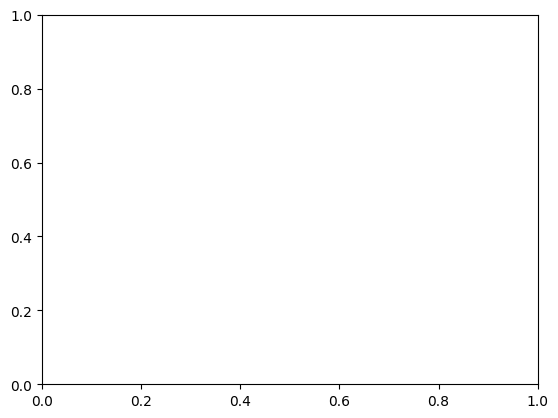

In [63]:
# def CAD_Mass_validation(df):
import matplotlib.pyplot as plt

x = BOM_pp.groupby(['CAD Material']).size()
y = BOM_pp.groupby(['CAD Material'])['CAD Mass']

plt.scatter(x, y)

In [ ]:
BOM_without_packaging[1:][BOM_without_packaging.UOM.isna()==True].groupby(['Source Code','Title']).size().sort_values(ascending=False)

C:\Users\mark_\AppData\Local\Temp\ipykernel_20676\2296961337.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  BOM_without_packaging[1:][BOM_without_packaging.UOM.isna()==True].groupby(['Source Code','Title']).size().sort_values(ascending=False)


Source Code  Title                  
BOP          TPP-MA017                  10
             TPP-MC481                   2
AIH          T48E-A02809_JOINING_ELE     1
BOF          T48E-A10799X                1
POA          T48E-A10213                 1
             T48E-A10211                 1
             T48E-A03849                 1
CON          T48E-A11303                 1
BOF          T48e-MF03-A03027            1
             T48E-CO99-A10278            1
             T48E-A10390                 1
AIH          T48E-A06100                 1
BOF          T48E-A10389                 1
             T48E-A06107                 1
             T48E-A06105                 1
             T48E-A06103                 1
             T48E-A06101                 1
AIH          T48E-A06106                 1
             T48E-A06104                 1
             T48E-A06102                 1
POA          T48E-A10215                 1
dtype: int64

In [ ]:
no_UOM = BOM_without_packaging[BOM_without_packaging.UOM.isna()]
pd.crosstab(no_UOM['Title'], no_UOM['Source Code'], margins=True, margins_name='Totals',)

Source Code,AIH,BOF,BOP,CON,POA,Totals
Title,,,,,,
T48E-A02809_JOINING_ELE,1,0,0,0,0,1
T48E-A03849,0,0,0,0,1,1
T48E-A06100,1,0,0,0,0,1
T48E-A06101,0,1,0,0,0,1
T48E-A06102,1,0,0,0,0,1
T48E-A06103,0,1,0,0,0,1
T48E-A06104,1,0,0,0,0,1
T48E-A06105,0,1,0,0,0,1
T48E-A06106,1,0,0,0,0,1


In [ ]:
part_val = BOM_ordered_without_packaging[1:][BOM_ordered_without_packaging['Level']>=4].filter(regex='Title|extr|length')
part_val.dropna(subset=['extr_invalid_code','extr_maturity'], how='all')

C:\Users\mark_\AppData\Local\Temp\ipykernel_20676\2738944723.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  part_val = BOM_ordered_without_packaging[1:][BOM_ordered_without_packaging['Level']>=4].filter(regex='Title|extr|length')


,Title,extr_function,extr_invalid_code,extr_maturity,extr_pn,extr_project,part_number_length
2633,T48e-A03553X,A,NaN,X,03553,T48e,12.0
2614,T48e-A02810X,A,NaN,X,02810,T48e,12.0
2689,T48e-MF03-A02810,A,MF03,NaN,02810,T48e,16.0
2669,T48e-A05080X,A,NaN,X,05080,T48e,12.0
2636,T48e-A03581X,A,NaN,X,03581,T48e,12.0
...,...,...,...,...,...,...,...
3660,T48e-CO99-A04583,A,CO99,NaN,04583,T48e,16.0
3676,T48e-MF03-A04583,A,MF03,NaN,04583,T48e,16.0
3539,T48e-A02937X,A,NaN,X,02937,T48e,12.0
3540,T48e-A02939X,A,NaN,X,02939,T48e,12.0
